**GAN Example with PyTorch, MatplotLib (CPU and CUDA supported)**

A simple implementation of a Generative Adversarial Network written with PyTorch

First of all we need some libraries that will be used throughout the demo:

*   PyTorch library (torch module)
*   The NeuralNetwork module (torch.nn module)
*   The DataLoader class which is used to load properly formatted train data (with optionally labels)
*   The torchvision module (specifically the transforms submodule and the make_grid function)
*   Finally the matplotlib module that will be used to display data visually

A freely available training data set will be used and imported directly from the torchvision module.

The FashionMNIST (originally from Zalando) includes 70K grayscale images of garments (28x28 pixels) grouped in 10 categories.

*   We will not build a supervised learning model, so the label set is not used in this example
*   The image dataset will be instead fed in an adversarial network to generate new images.





In [10]:
# import pytorch and the NeuralNet library
import torch
import torch.nn as nn

# import the DataLoader utility class
# A dataset represents data and labels
# DataLoader wraps dataset into an iterable object
from torch.utils.data import DataLoader

# import vision-related utilities
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# import dataset
from torchvision.datasets import FashionMNIST as dataset

# import pyplot for visualization
import matplotlib.pyplot as plt

# import python debugger
import pdb

# python OS libraries
import os
from typing import Union, AnyStr, Callable, Any

# install and import wandb
!pip install wandb
try:
  import wandb as wb
except:
  print("Module not found")

Let's also define an utility class to hold every non-nn related function.

We define some useful functions that can be used an re-used throughout the demo, to debug code or to display data from the training set.

* plot(): function that converts tensor data into a variable size grid of images and displays them using matplotlib
* download_dataset(): utility function that download the MNIST dataset from the network and returns DataLoader Iterator object
* get_processor_type(): queries pytorch for the underlying processor type. Automatically selects 'cpu' or 'cuda' as device type depending on hardware availability

The dataset iterator uses the batch_size variable to determine how many samples it needs to return to the caller for every iteration of the training process.

Upon load, the dataset needs to be converted to a [N x W x L] PyTorch Tensor from a [W x L x N] rgb image:
* transforms.ToTensor() method is used during the load operation to convert image data bytes to a PyTorch Tensor
* the tensor.view() method is used to reshape the data array: training data comes in as a [N x K] array, where K = color depth x width x height. Output tensor is reshaped as [N x C x W x H]

In [11]:
# Class utility: holds utility functions and code not directly related to the NN
# this will mostly contain only class methods
class Utilities(object):
  def __init__(self):
    super().__init__()

  # display data from the current tensor
  @classmethod
  def plot(self: object, tensor_data: torch.Tensor, channels: int=1, size: list=(28,28), num_items: int=16, num_rows:int =4) -> None:
    # we use detach() to remove this computation from the computation of back propagation parameters.
    # then, reshape the data to a meaningful representation for displaying images
    # original size: n x 768 (28*28) -> n * 1 * 28 * 28
    # whre n is the learning batch size
    plot_data = tensor_data.detach().cpu().view(-1, channels, *size)

    # display data in a grid
    # matplotlib expects data with this format (rows, cols, channels)
    # tensor is now formatted like this (channels, rows, cols)
    # we need to swap data components
    display_grid = make_grid(plot_data[:num_items], nrow=int(num_items/num_rows)).permute([1,2,0])

    # show data
    plt.imshow(display_grid)
    plt.show()

  # download and prepare the dataset
  @classmethod
  def download_dataset(self: object, iterator: bool =False, batch_size: int=128, download: bool=True, shuffle: bool=True, train_data: bool=False) -> Union[DataLoader,iter]:
    # get and load the dataset, return an iterator
    dataset_download = dataset('.', transform=ToTensor(), download=download, train=train_data)
    loaded_dataset = DataLoader(dataset_download, batch_size=batch_size, shuffle=shuffle)

    # return the iterator
    return iter(loaded_dataset) if iterator else loaded_dataset

  # explore dataset
  @classmethod
  def dataset_features(self: object, datapoint: torch.Tensor) -> None:
    if type(datapoint) == torch.Tensor:
      print(f"DataPoint {type(datapoint)}: dimensions: {datapoint.shape}")
    else:
      print("Not a Torch Tensor")

  # determine which kind of processing environment we can use
  @classmethod
  def get_processor_type(self: object) -> AnyStr:
    processor_device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # return the detected processor type
    return processor_device

  # utility functions to save or load checkpoints
  @classmethod
  def save_model_checkpoint(self: object, gan: object, epoch: int, gen_checkpoint_file: str, dect_checkpoint_file: str) -> None:
    gen_model = {
        "model": gan.generator.state_dict(),
        "optimizer": gan.generator_optimizer.state_dict(),
        "epoch": epoch
    }
    dect_model = {
        "model": gan.detector.state_dict(),
        "optimizer": gan.detector_optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(gen_model, gen_checkpoint_file)
    torch.save(dect_model, dect_checkpoint_file)

  @classmethod
  def load_model_checkpoint(self: object, gan: object, gen_checkpoint_file: str, dect_checkpoint_file: str) -> None:
    if os.path.exists(gen_checkpoint_file):
      print(f"Loading model {gen_checkpoint_file}")
      gan.generator.load_state_dict(torch.load(gen_checkpoint_file).get("model"))
      gan.generator_optimizer.load_state_dict(torch.load(gen_checkpoint_file).get("optimizer"))

    if os.path.exists(dect_checkpoint_file):
      print(f"Loading model {dect_checkpoint_file}")
      gan.detector.load_state_dict(torch.load(dect_checkpoint_file).get("model"))
      gan.detector_optimizer.load_state_dict(torch.load(dect_checkpoint_file).get("optimizer"))


Now let's define the network parameters

*   Epochs (how many learning phases we will perform)

and some hyperparameters:

*   Batch Size (how many datpoints from the dataset we are going to process per iteration)
*   Learning Rate (a number that is used to tweak how fast the network is learning)
*   Latent Space Size (the indicative number of data features that the neural network is able to learn from data)

During each Epoch, the neural network will be fed a number of samples to analyze.

The dataset used in this demo contains 70K images:
* Each Epoch te network will process all images while progressively tuning its parameters according to a computed cost/loss function via backpropagation
* During each Epoch, data will be analyzed in batches of size B, so for each epoch, K=size(Dataset)/B iterations will be performed

In [12]:
epochs: int = 500
display_progress_interval: int = 25 # Display learning progress every 25 epochs
batch_size: int = 256 # 128 images from the training set are fed to the neural network every iteration in an epoch
learning_rate: float = 2e-4
latent_space_size: int = 64 # number of features we'd like the network to learn from data

# generator image output size
gen_output_size: int = 28 * 28 # depends on training input data

# nn mode
# if train_mode is 0, assume no prior training, so train the network
# if train_mode is 1, skip training and load saved model
train_mode: bool = True

# model checkpoint file names
generator_model: str = "gan_generator_model.pth"
detector_model: str = "gan_detector_model.pth"

# weights and biases login information
wandb_apikey_file: str = "wandb-apikey"
apikey: str = ""
login_completed = False
try:
  f = os.open(wandb_apikey_file, os.O_RDONLY)
  apikey = os.read(f, 1024).decode('utf-8').strip()
  # login to wandb
  login_completed = wb.login(key=apikey)
except FileNotFoundError as e:
  print(f"Cannot find apikey file: {e}")
except Exception as e:
  print(f"{e}")

if not login_completed:
  raise Exception("Login to Weights and Biases failed.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Neural Network Generation Utilities**

This class implements utilities that will deal with the Neural Network implementation.

*   Method that generate a neuron block
*   Mehtods that generate synthetic data to feed to the neural network



In [13]:
# The Neural Net block generator
class NeuralNetUtils(object):
  def __init__(self):
    super().__init__()

  # build a neural network node
  @classmethod
  def generate_sequential_linear_block(self: object, input_size: int, output_size: int) -> nn.Sequential:
    block = nn.Sequential( # a neural net layer, apply module sequentially
        nn.Linear(input_size, output_size),
        nn.BatchNorm1d(output_size),
        nn.ReLU(inplace=True)
    )
    return block

  # generate a random input image (noise input)
  # this return a structure with size [N x L] where N is the number of synthetic
  # data points and L is the size of the latent space
  @classmethod
  def random_std_noise(self: object, synthetic_datapoint_number: int, latent_space_size: int) -> torch.Tensor:
    return torch.randn(synthetic_datapoint_number, latent_space_size)

Declare both the Generator and the Detector neural networks.

* Generator class: generates a random image based on the neural net weights values. Outputs an array of values bounded between 0 and 1 representing a new image
* Detector class: evaluates input data based on the neural net weights. Output a single value, 0 if it detects a fake image, 1 if it detects a real image

In [14]:
# Declare the Generator Neural Network
class Generator(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_layer_size: int):
    super().__init__()
    self.generator = nn.Sequential(
        NeuralNetUtils.generate_sequential_linear_block(input_size, hidden_layer_size * 2),
        NeuralNetUtils.generate_sequential_linear_block(hidden_layer_size * 2, hidden_layer_size * 4),
        NeuralNetUtils.generate_sequential_linear_block(hidden_layer_size * 4, hidden_layer_size * 8),
        NeuralNetUtils.generate_sequential_linear_block(hidden_layer_size * 8, output_size),
        nn.Sigmoid() # normalize output between [0,1]
    )

  # generate next output
  def forward(self, input_data: torch.Tensor) -> torch.Tensor:
    return self.generator(input_data)

# Declare the Detector Neural Network
class Detector(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_layer_size: int): # output is [0,1], real or fake
    super().__init__()
    self.detector = nn.Sequential(
        NeuralNetUtils.generate_sequential_linear_block(input_size, hidden_layer_size * 2),
        NeuralNetUtils.generate_sequential_linear_block(hidden_layer_size * 2, hidden_layer_size * 4),
        NeuralNetUtils.generate_sequential_linear_block(hidden_layer_size * 4, hidden_layer_size * 8),
        NeuralNetUtils.generate_sequential_linear_block(hidden_layer_size * 8, hidden_layer_size),
        nn.Linear(hidden_layer_size, 1),
        nn.Sigmoid()
    )

  # generate next output
  def forward(self, input_data: torch.Tensor) -> torch.Tensor:
    return self.detector(input_data)

Declare the actual GAN class

* Create a Generator and a Detector, and put them one against the other
* Use ADAM as the underlying parameter optimizer algorithm
* Generate images with the Generator (fake, from noise), attach output value of one, backpropagate
* Use the Detector to evaluate the output of the generator to a real image and compute the prediction, backpropagate

Also, declare some test and statistics functions to evaluate the training process

In [15]:
# generator loss function (Binary Cross Entropy)
# it takes tensor noise data as input for the generator
# and passes the resulting generated data through the detector
# target weights are set to 1, meaning that the image must be interpreted as "real"
def generator_loss_function(generator: Generator, detector: Detector, generator_input: torch.Tensor, function: Callable=nn.BCELoss()) -> Any:
  synth_image: torch.Tensor = generator(generator_input)
  proof_image: torch.Tensor = detector(synth_image)
  weight_target: torch.Tensor = torch.ones_like(proof_image.detach())

  return function(proof_image, weight_target) # normalize input before computing loss

# detector loss function
# same here but we calculate loss for the whole GAN
# this time the target of the generator is set to 0 to let the detector learn how to spot fake images
# and the detector also calculates loss with respect to a set of "real" images (target weights = 1)
def detector_loss_function(generator: Generator, detector: Detector, generator_input: torch.Tensor, detector_input: torch.Tensor, function: Callable=nn.BCELoss()) -> Any:
  synth_image = generator(generator_input)
  proof_image = detector(synth_image.detach()) # use data to calculate the detector loss but do not backpropagate on the generator: we are training the detector here
  gen_weight_target = torch.zeros_like(proof_image)
  gen_loss = function(proof_image, gen_weight_target) # normalize input before computing loss

  train_image = detector(detector_input)
  dect_weight_target = torch.ones_like(train_image)
  dect_loss = function(train_image, dect_weight_target) # normalize input before computing loss

  return (dect_loss + gen_loss)/2 # mean loss

# test model
def test_model(model, batch_size):
  accuracy = 0
  loss = 0
  with torch.no_grad():
    fake_input = NeuralNetUtils.random_std_noise(batch_size, model.i_size).to(model.device)
    fake = model.generator(fake_input)
    Utilities.plot(fake, num_rows=1)
    # make a prediction
    prediction = model.detector(fake)
    return prediction

# build the GAN object
class GenerativeNetwork(object):
  def __init__(self, dataset: Union[DataLoader, iter], input_size: int,
               output_size: int, hidden_layer_size: int, learning_rate: float,
               generator_checkpoint_file: str, detector_checkpoint_file: str, checkpoint_enabled: bool = True) -> object:
    # dataset iterator
    self.data_iterator: Union[DataLoader, iter] = dataset

    # detect processor type
    self.device: str = Utilities.get_processor_type()
    print(f"Running model on device {self.device}")

    # params
    self.i_size: int = input_size
    self.o_size: int = output_size
    self.h_size: int = hidden_layer_size
    self.lr: float = learning_rate

    # checkpointing
    self.generator_model = generator_checkpoint_file
    self.detector_model = detector_checkpoint_file
    self.checkpoint_enabled = checkpoint_enabled

    # build the generator neural net
    self.generator: Generator = Generator(self.i_size, self.o_size, self.h_size).to(self.device)
    self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
    print(f"Storing Generator Model on device {next(self.generator.parameters()).device}")

    # build the detector neural net
    self.detector: Detector = Detector(self.o_size, 1, self.h_size).to(self.device)
    self.detector_optimizer = torch.optim.Adam(self.detector.parameters(), lr=self.lr)
    print(f"Storing Detector Model on device {next(self.detector.parameters()).device}")

  # train the model
  def train(self, batch_size: int, epochs: int) -> None:
    num_batches: int = len(self.data_iterator)
    for e in range(epochs):
      print(f"\nCurrent Epoch: {e} -----------------------------")
      iteration: int = 0
      # zero out statistics
      dect_loss: int = 0
      gen_loss: int = 0

      # Show progress
      if e % display_progress_interval == 0 and e > 0:
        test_model(self, 4)
        if self.checkpoint_enabled:
          print(f"--- Saving checkpoint at epoch {e} -----------------")
          Utilities.save_model_checkpoint(self, e, self.generator_model, self.detector_model)

      # training loop
      for train_data, _ in self.data_iterator:
        current_step: int = len(train_data)

        # reset the gradient on the generator
        self.generator_optimizer.zero_grad()
        # train the generator
        fake_input: torch.Tensor = NeuralNetUtils.random_std_noise(self.data_iterator.batch_size, self.i_size).to(self.device)
        generator_loss = generator_loss_function(self.generator, self.detector, fake_input)
        generator_loss.backward()
        self.generator_optimizer.step()

        # reset the gradient on the detector
        self.detector_optimizer.zero_grad()
        # train the detector
        fake_input: torch.Tensor = NeuralNetUtils.random_std_noise(self.data_iterator.batch_size, self.i_size).to(self.device)
        real_input: torch.Tensor = train_data.view(current_step, -1).to(self.device)
        detector_loss = detector_loss_function(self.generator, self.detector, fake_input, real_input)
        detector_loss.backward()
        self.detector_optimizer.step()

        # update statistics
        iteration += 1
        dect_loss += detector_loss.item()/current_step
        gen_loss += generator_loss.item()/current_step
        print(f"\rProcessed {current_step} samples | Current Batch: [{iteration} / {num_batches}]" +
              f" Epoch {100*iteration/num_batches}% | Generator Loss: {gen_loss} | Detector Loss: {dect_loss}", end="", flush=True)

      # log loss values after an epoch
      wb.log(
          {
              "epoch": e,
              "gen_loss": gen_loss,
              "dect_loss": dect_loss
          }
      )


Start up and train the model on available hardware (CPU or GPU are autodetected)

In [16]:
# neural network setup and training process
# get the dataset
data_set = Utilities.download_dataset(batch_size=batch_size)

# instantiate the GAN Network
gan = GenerativeNetwork(data_set, latent_space_size, gen_output_size, 256, learning_rate, generator_model, detector_model)

# setup experiment in wandb
wb.init(
    # set the wandb project where this run will be logged
    project="gan-demo-cuda",

    # track hyperparameters and run metadata
    config={
      "learning_rate": learning_rate,
      "architecture": "GAN",
      "dataset": "FashionMNIST",
      "epochs": epochs,
      "batch_size": batch_size,
      "latent_space_size": latent_space_size,
      "training_device": Utilities.get_processor_type()
    }
)
# instruct wandb to watch model statistics
wb.watch(gan.generator, log_freq=100)
wb.watch(gan.detector, log_freq=100)

# load checkpoints
Utilities.load_model_checkpoint(gan, generator_model, detector_model)

Running model on device cuda
Storing Generator Model on device cuda:0
Storing Detector Model on device cuda:0


Train and save the resulting model.


Current Epoch: 0 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.18060160288587213 | Detector Loss: 0.12839743099175394
Current Epoch: 1 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.2315037865191698 | Detector Loss: 0.10357872233726084
Current Epoch: 2 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.2794908103533089 | Detector Loss: 0.08257504657376558
Current Epoch: 3 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.3246190771460533 | Detector Loss: 0.07212926732609048
Current Epoch: 4 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.3756607170216739 | Detector Loss: 0.0604576634359546
Current Epoch: 5 -----------------------------
Processed 16 samples | Current Batch: [40 

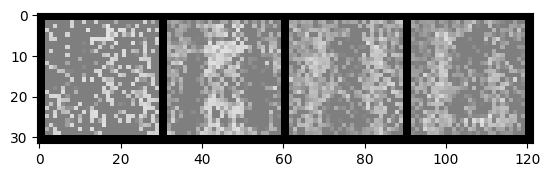

--- Saving checkpoint at epoch 25 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8001017989590764 | Detector Loss: 0.04582193103124155
Current Epoch: 26 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.7737618992105126 | Detector Loss: 0.02168375644396292
Current Epoch: 27 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.794082029722631 | Detector Loss: 0.016628470832074527
Current Epoch: 28 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8007408371195197 | Detector Loss: 0.025078995247895364
Current Epoch: 29 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.7943532718345523 | Detector Loss: 0.03077111731545301
Current Epoch: 30 -----------------------------
Processed 16 samples | Current B

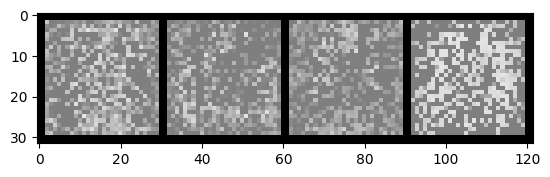

--- Saving checkpoint at epoch 50 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9269737424328923 | Detector Loss: 0.005067838501418009
Current Epoch: 51 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9760578460991383 | Detector Loss: 0.012698227754299296
Current Epoch: 52 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9707346893846989 | Detector Loss: 0.006695576281344984
Current Epoch: 53 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9538620356470346 | Detector Loss: 0.032309976166288834
Current Epoch: 54 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9227826707065105 | Detector Loss: 0.024532302930310834
Current Epoch: 55 -----------------------------
Processed 16 samples | Curre

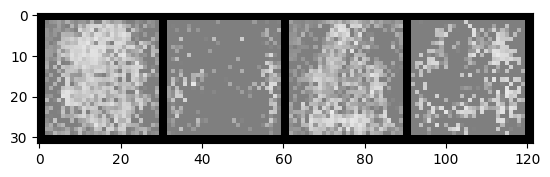

--- Saving checkpoint at epoch 75 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9343218449503183 | Detector Loss: 0.06692251098866109
Current Epoch: 76 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9054646426811814 | Detector Loss: 0.015295995173801202
Current Epoch: 77 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.971941489726305 | Detector Loss: 0.08856701445620274
Current Epoch: 78 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8081851564347744 | Detector Loss: 0.04571975104045123
Current Epoch: 79 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8388340650126338 | Detector Loss: 0.07893369285739027
Current Epoch: 80 -----------------------------
Processed 16 samples | Current Ba

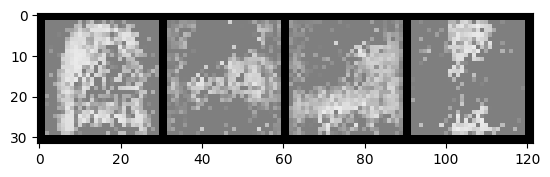

--- Saving checkpoint at epoch 100 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0068143140524626 | Detector Loss: 0.07324267339754442
Current Epoch: 101 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9046413488686085 | Detector Loss: 0.08717838497250341
Current Epoch: 102 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9897984890267253 | Detector Loss: 0.011835829438496148
Current Epoch: 103 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8893749499693513 | Detector Loss: 0.07537083831994096
Current Epoch: 104 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9285331927239895 | Detector Loss: 0.10294407064793631
Current Epoch: 105 -----------------------------
Processed 16 samples | Cur

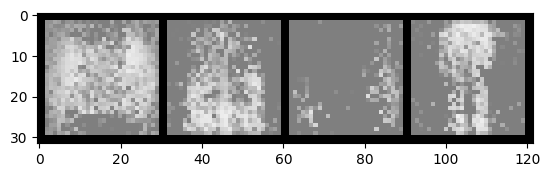

--- Saving checkpoint at epoch 125 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0327230477705598 | Detector Loss: 0.030626562707766425
Current Epoch: 126 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.7563436655327678 | Detector Loss: 0.16159643968057935
Current Epoch: 127 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8805811489000916 | Detector Loss: 0.021139922873771866
Current Epoch: 128 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.075726868584752 | Detector Loss: 0.09786045000510057
Current Epoch: 129 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0344221638515592 | Detector Loss: 0.07806393720238702
Current Epoch: 130 -----------------------------
Processed 16 samples | Cur

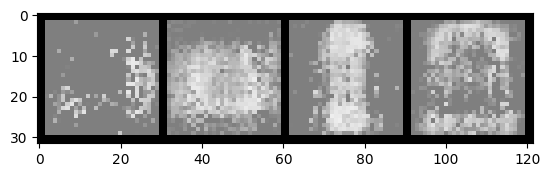

--- Saving checkpoint at epoch 150 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9961399734020233 | Detector Loss: 0.052605109187425114
Current Epoch: 151 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8934619352221489 | Detector Loss: 0.026912536945019383
Current Epoch: 152 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8896213863044977 | Detector Loss: 0.08525247248326195
Current Epoch: 153 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9739647628739476 | Detector Loss: 0.0670521215070039
Current Epoch: 154 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9791269078850746 | Detector Loss: 0.11441302113962593
Current Epoch: 155 -----------------------------
Processed 16 samples | Cur

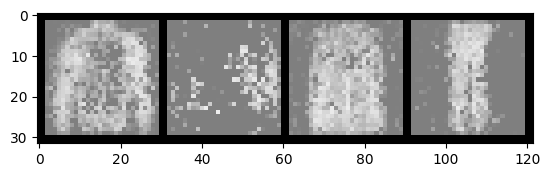

--- Saving checkpoint at epoch 175 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0045233182609081 | Detector Loss: 0.07623477489687502
Current Epoch: 176 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.1416350193321705 | Detector Loss: 0.04439394657310913
Current Epoch: 177 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.1493943138048053 | Detector Loss: 0.030578610338125145
Current Epoch: 178 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9842712553218007 | Detector Loss: 0.07808552245842293
Current Epoch: 179 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.1347822528332472 | Detector Loss: 0.01694568186212564
Current Epoch: 180 -----------------------------
Processed 16 samples | Cur

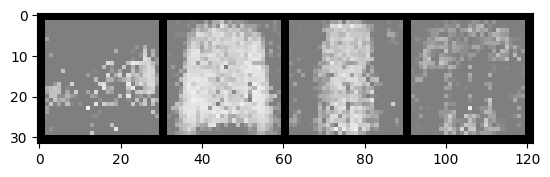

--- Saving checkpoint at epoch 200 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9871225273236632 | Detector Loss: 0.10308331273699878
Current Epoch: 201 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9732107752934098 | Detector Loss: 0.07551481913105818
Current Epoch: 202 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.862843775190413 | Detector Loss: 0.06443016106641153
Current Epoch: 203 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.1260198028758168 | Detector Loss: 0.11983943148879916
Current Epoch: 204 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8619866659864783 | Detector Loss: 0.06525276264801505
Current Epoch: 205 -----------------------------
Processed 16 samples | Curre

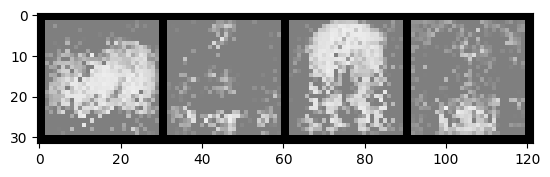

--- Saving checkpoint at epoch 225 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9201686512678862 | Detector Loss: 0.02826750139865908
Current Epoch: 226 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0711894119158387 | Detector Loss: 0.08990368732702336
Current Epoch: 227 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9370938679203391 | Detector Loss: 0.11898721248144284
Current Epoch: 228 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8722473913803697 | Detector Loss: 0.06011908604341443
Current Epoch: 229 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.964088904671371 | Detector Loss: 0.06672248210816178
Current Epoch: 230 -----------------------------
Processed 16 samples | Curre

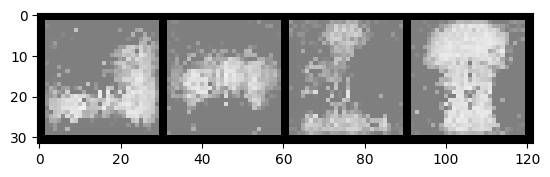

--- Saving checkpoint at epoch 250 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9670336144044995 | Detector Loss: 0.06568272106233053
Current Epoch: 251 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8534625209867954 | Detector Loss: 0.07587514245096827
Current Epoch: 252 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.827452682889998 | Detector Loss: 0.11714525718707591
Current Epoch: 253 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8393147140741348 | Detector Loss: 0.01152366636597435
Current Epoch: 254 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8726948061957955 | Detector Loss: 0.019854535745253088
Current Epoch: 255 -----------------------------
Processed 16 samples | Curr

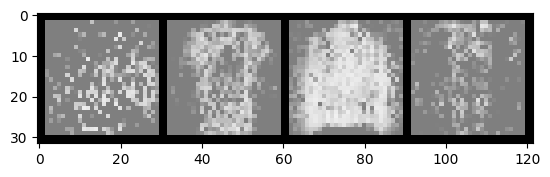

--- Saving checkpoint at epoch 275 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9873020332306623 | Detector Loss: 0.14605899631715147
Current Epoch: 276 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9036188302561641 | Detector Loss: 0.04707322248032142
Current Epoch: 277 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8745394358411431 | Detector Loss: 0.09619671536347596
Current Epoch: 278 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9055815823376179 | Detector Loss: 0.08950573408947093
Current Epoch: 279 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9896288681775331 | Detector Loss: 0.19587017028970877
Current Epoch: 280 -----------------------------
Processed 16 samples | Curr

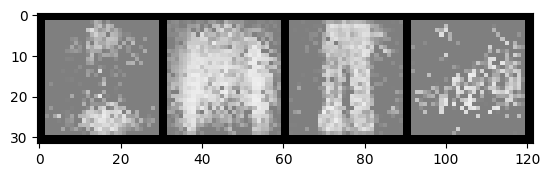

--- Saving checkpoint at epoch 300 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9219312118366361 | Detector Loss: 0.08735555699968245
Current Epoch: 301 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8874365887604654 | Detector Loss: 0.1323390189681959
Current Epoch: 302 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8606085442006588 | Detector Loss: 0.024018499039812014
Current Epoch: 303 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.1449482897296548 | Detector Loss: 0.07864877532847458
Current Epoch: 304 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.1521309837698936 | Detector Loss: 0.10701893375153304
Current Epoch: 305 -----------------------------
Processed 16 samples | Curr

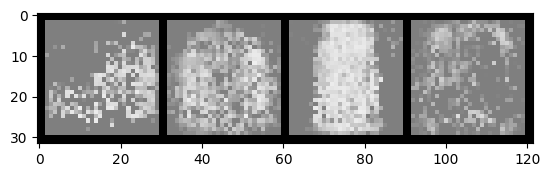

--- Saving checkpoint at epoch 325 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9617030303925276 | Detector Loss: 0.06461445710010594
Current Epoch: 326 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9984145993366838 | Detector Loss: 0.024311567831318825
Current Epoch: 327 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.250394362024963 | Detector Loss: 0.09132290904744877
Current Epoch: 328 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.2004899866878986 | Detector Loss: 0.016214852588745998
Current Epoch: 329 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9153343765065074 | Detector Loss: 0.0438155567026115
Current Epoch: 330 -----------------------------
Processed 16 samples | Curr

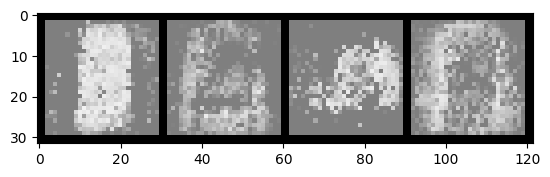

--- Saving checkpoint at epoch 350 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0934236571192741 | Detector Loss: 0.08253815419448074
Current Epoch: 351 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9555086744949222 | Detector Loss: 0.15948212809598772
Current Epoch: 352 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0575163685716689 | Detector Loss: 0.05964499194305972
Current Epoch: 353 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8719839481636882 | Detector Loss: 0.10343596439633984
Current Epoch: 354 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0393781950697303 | Detector Loss: 0.02555155853224278
Current Epoch: 355 -----------------------------
Processed 16 samples | Curr

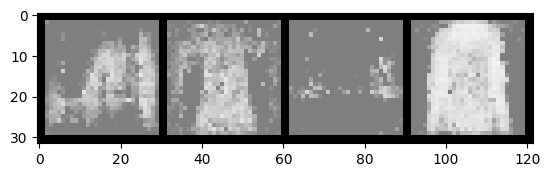

--- Saving checkpoint at epoch 375 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9403433515690267 | Detector Loss: 0.07911255324142985
Current Epoch: 376 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8284042393788695 | Detector Loss: 0.052158634207444265
Current Epoch: 377 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9580013670492917 | Detector Loss: 0.05460670441243565
Current Epoch: 378 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9979328000918031 | Detector Loss: 0.0420817341619113
Current Epoch: 379 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8345798468217254 | Detector Loss: 0.03349671583782765
Current Epoch: 380 -----------------------------
Processed 16 samples | Curr

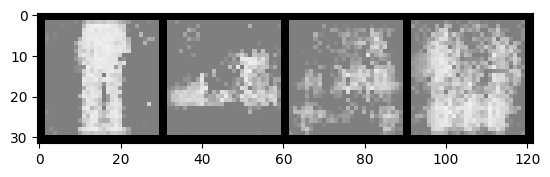

--- Saving checkpoint at epoch 400 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.828844771720469 | Detector Loss: 0.12354058375785826
Current Epoch: 401 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8659018129110336 | Detector Loss: 0.09109484486543806
Current Epoch: 402 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9834220828488469 | Detector Loss: 0.04506731154924637
Current Epoch: 403 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9000413350295275 | Detector Loss: 0.06558101580594666
Current Epoch: 404 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9362810007296503 | Detector Loss: 0.07406893230654532
Current Epoch: 405 -----------------------------
Processed 16 samples | Curre

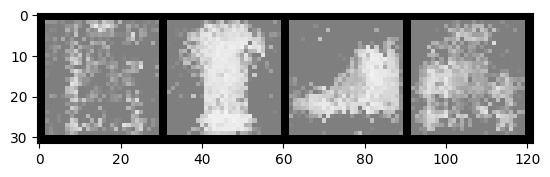

--- Saving checkpoint at epoch 425 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9924972280859947 | Detector Loss: 0.04106487051103613
Current Epoch: 426 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.7990832960349508 | Detector Loss: 0.05048055373481475
Current Epoch: 427 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8981903190724552 | Detector Loss: 0.07474169572378742
Current Epoch: 428 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8594783507287502 | Detector Loss: 0.024808472919175983
Current Epoch: 429 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0195855158381164 | Detector Loss: 0.10538131763132697
Current Epoch: 430 -----------------------------
Processed 16 samples | Cur

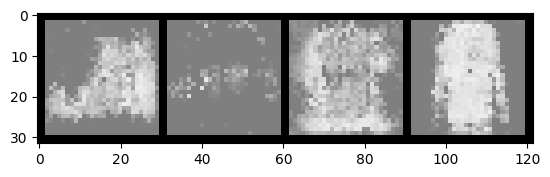

--- Saving checkpoint at epoch 450 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.709932547993958 | Detector Loss: 0.07158848270046292
Current Epoch: 451 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8323409669101238 | Detector Loss: 0.05538812873419374
Current Epoch: 452 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.008571139536798 | Detector Loss: 0.05073100955996779
Current Epoch: 453 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.0735443974845111 | Detector Loss: 0.03276047352483147
Current Epoch: 454 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9901187671348453 | Detector Loss: 0.036927553210261976
Current Epoch: 455 -----------------------------
Processed 16 samples | Curre

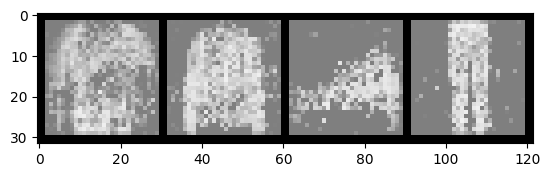

--- Saving checkpoint at epoch 475 -----------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.002576523926109 | Detector Loss: 0.10300899477988423
Current Epoch: 476 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 1.009262845851481 | Detector Loss: 0.06505866239604075
Current Epoch: 477 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.8972170674242079 | Detector Loss: 0.11903504925066954
Current Epoch: 478 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9210828696377575 | Detector Loss: 0.0633998700286611
Current Epoch: 479 -----------------------------
Processed 16 samples | Current Batch: [40 / 40] Epoch 100.0% | Generator Loss: 0.9938058410771191 | Detector Loss: 0.061512865093391156
Current Epoch: 480 -----------------------------
Processed 16 samples | Curren

dect_loss,▃▁▁▂▁▃▄▂▃▆▁▅▃▃▁▅▅▅▃▂▄██▇▂▂▂▅▄▂▃▄▃▄▃▄▄▇▃▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
gen_loss,▁▄▅▅▇▇▅▇▆▆▆▆▆▆█▇██▆▆▆█▇▆█▇▇▆▇▆▇▆▆▇▅▅▅▆▇▆
dect_loss,0.03308
epoch,499
gen_loss,0.91973


In [17]:
# start neural network training
if train_mode is True:
  gan.train(batch_size, epochs)

# finish experiment, log out from wandb
wb.finish()

Now try to use the generator to output a new image and measure the network accuracy

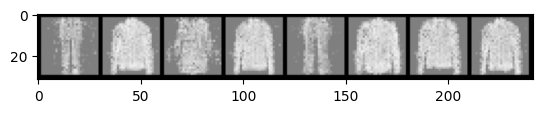

In [18]:
fake_input = NeuralNetUtils.random_std_noise(batch_size, gan.i_size).to(gan.device)
Utilities.plot(gan.generator(fake_input), num_items=8, num_rows=1)

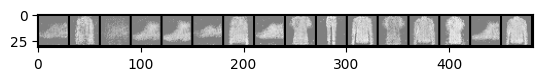

tensor([[3.2369e-03],
        [6.2495e-03],
        [1.8090e-03],
        [6.8048e-03],
        [1.5662e-03],
        [1.3747e-02],
        [1.7617e-02],
        [6.1418e-03],
        [7.8692e-03],
        [6.7388e-03],
        [8.6011e-03],
        [1.4812e-02],
        [6.7714e-03],
        [2.0855e-02],
        [3.1862e-03],
        [2.7524e-03],
        [3.3020e-03],
        [2.0874e-03],
        [4.2880e-03],
        [4.4271e-03],
        [5.9192e-03],
        [1.3418e-02],
        [3.3175e-02],
        [1.2136e-03],
        [1.1016e-02],
        [3.6990e-02],
        [4.5029e-03],
        [5.5418e-03],
        [7.2670e-03],
        [3.5984e-02],
        [1.3116e-02],
        [3.4702e-03],
        [7.9212e-03],
        [8.2076e-03],
        [5.8271e-03],
        [5.3235e-03],
        [4.5428e-03],
        [8.0143e-03],
        [3.0767e-02],
        [1.5693e-03],
        [6.0557e-03],
        [2.5451e-03],
        [8.1880e-03],
        [1.6719e-02],
        [4.1837e-03],
        [8

In [19]:
w = test_model(gan, batch_size)
print(w)